#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

#Data Preprocessing and Augmentation

In [ ]:
train = ImageFolder("D:/Selise Assesment/Selise Dataset/dataset/train", transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))
train_dl = DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
        
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

(tensor([0.4988, 0.4491, 0.3663]), tensor([0.2574, 0.2453, 0.2671]))

In [ ]:
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [ ]:
train = ImageFolder("D:/Selise Assesment/Selise Dataset/dataset/train", transform = train_transform)
test = ImageFolder("D:/Selise Assesment/Selise Dataset/dataset/test",transform = test_transform)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
#validation size maintaining
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(3840, 960)

In [ ]:
batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

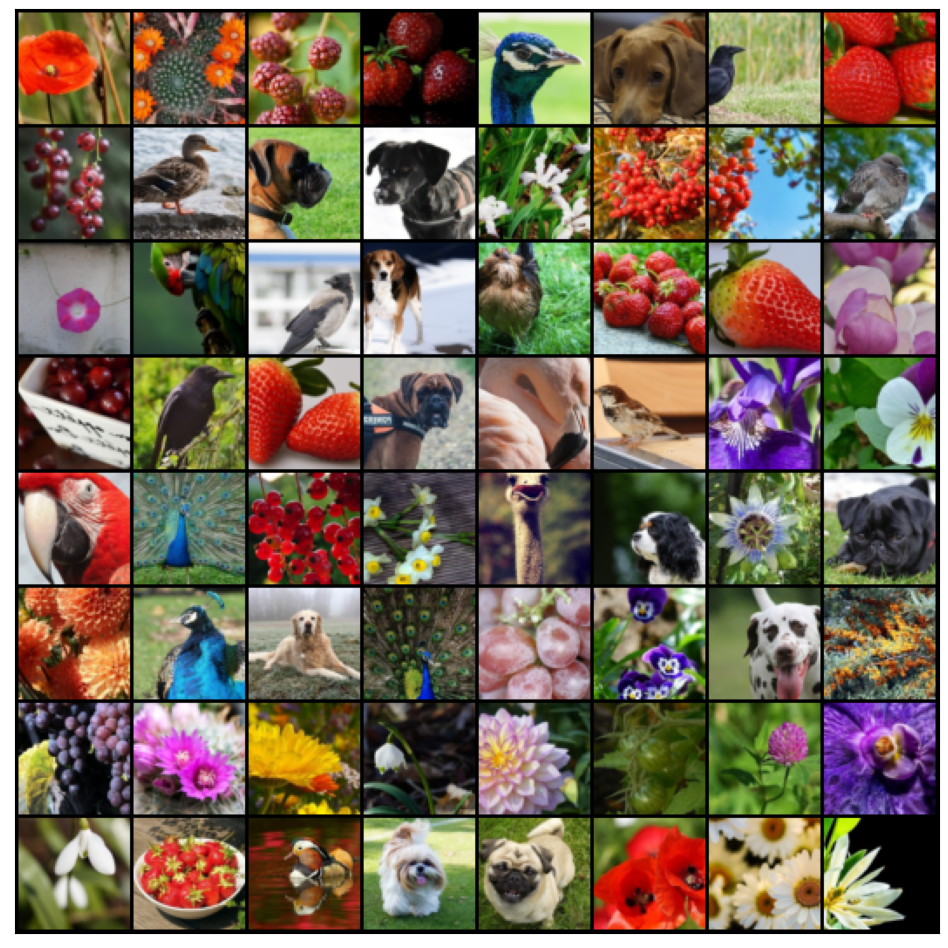

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#Building the hyperparameters of first Neural Network respectively the Neural Network itself

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
no_of_classes = len(train.classes)
no_of_classes

4

#Training First NN

In [ ]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3872771263122559, 'val_acc': 0.2483723908662796}]

In [ ]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00204, train_loss: 1.2464, val_loss: 1.9661, val_acc: 0.4814
Epoch [1], last_lr: 0.00597, train_loss: 0.9062, val_loss: 1.6650, val_acc: 0.5866
Epoch [2], last_lr: 0.00935, train_loss: 0.9275, val_loss: 2.2329, val_acc: 0.4447
Epoch [3], last_lr: 0.00994, train_loss: 0.9174, val_loss: 0.7881, val_acc: 0.6715
Epoch [4], last_lr: 0.00933, train_loss: 0.8069, val_loss: 0.9117, val_acc: 0.6009
Epoch [5], last_lr: 0.00812, train_loss: 0.8382, val_loss: 0.8477, val_acc: 0.6504
Epoch [6], last_lr: 0.00647, train_loss: 0.6747, val_loss: 0.7840, val_acc: 0.6676
Epoch [7], last_lr: 0.00463, train_loss: 0.5801, val_loss: 0.5799, val_acc: 0.7445
Epoch [8], last_lr: 0.00283, train_loss: 0.5095, val_loss: 0.5222, val_acc: 0.7809
Epoch [9], last_lr: 0.00133, train_loss: 0.4703, val_loss: 0.5279, val_acc: 0.7780
Epoch [10], last_lr: 0.00035, train_loss: 0.4400, val_loss: 0.4805, val_acc: 0.7982
Epoch [11], last_lr: 0.00000, train_loss: 0.3941, val_loss: 0.4792, val_acc: 0.7992
Wa

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

#Loss Curve

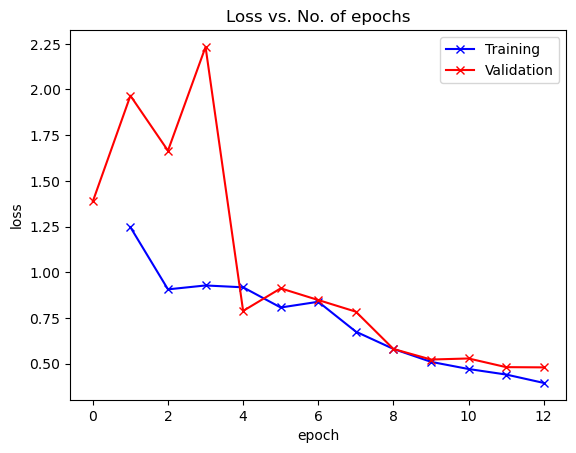

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

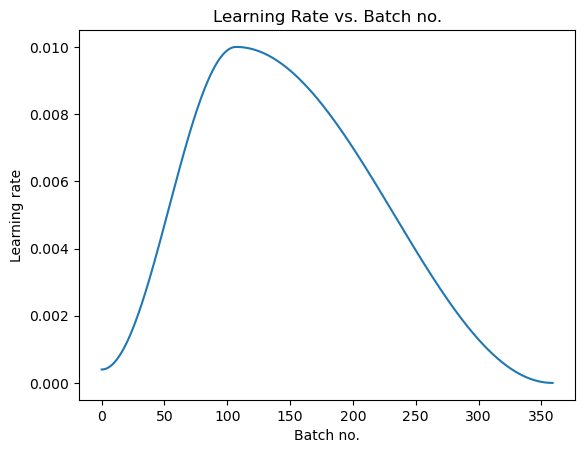

In [ ]:
plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.49421316385269165, 'val_acc': 0.8152901530265808}

### Accuracy is not likely satisfactory. 

#Ensemble Approach 

In [ ]:
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
import operator
import torchvision.transforms as transforms 
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

In [ ]:
train_dir = "D:/Selise Assesment/Selise Dataset/dataset/train"
test_dir = "D:/Selise Assesment/Selise Dataset/dataset/test"
pred_dir = "D:/Selise Assesment/Selise Dataset/dataset/valid"

BATCH_SIZE = 64
EPOCHS = 9
CLASSES = os.listdir(train_dir)
metric = 0

In [ ]:
device = torch.device('cpu')
device

device(type='cpu')

#Hyperparameter setting and model building for ensemble approaches

In [ ]:
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

In [ ]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    if seed == 0 or seed == 1:
        mls_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2], gamma=0.1)
        return criterion, optimizer, lrp_scheduler, mls_scheduler
    else:
        return criterion, optimizer, lrp_scheduler

In [ ]:
def model_archive(seed):
    if seed == 0:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=len(CLASSES)),
        )
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed) 
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 1:
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model = model_adjustment(model)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 2:
        model = timm.create_model('ens_adv_inception_resnet_v2', pretrained=True)
        model = model_adjustment(model)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 3:
        model = torchvision.models.densenet201(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 4:
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model = model_adjustment(model)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler

In [ ]:
# VGG19 with batch-normalization
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg, mls_scheduler_vgg = model_archive(seed = 0)

# ViT (Vision Transformer)
model_vit, criterion_vit, optimizer_vit, lrp_scheduler_vit, mls_scheduler_vit = model_archive(seed = 1)

# Ensemble Adversarial Inception-ResNet v2
model_eairv, criterion_eairv, optimizer_eairv, lrp_scheduler_eairv = model_archive(seed = 2)

# DenseNet201 classifier
model_dn, criterion_dn, optimizer_dn, lrp_scheduler_dn = model_archive(seed = 3)

# ResNeXt50_32 Classifier
model_rnx, criterion_rnx, optimizer_rnx, lrp_scheduler_rnx = model_archive(seed = 4)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ens_adv_inception_resnet_v2-2592a550.pth" to C:\Users\Notebook/.cache\torch\hub\checkpoints\ens_adv_inception_resnet_v2-2592a550.pth
C:\Users\Notebook\anaconda3\envs\selise\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\Notebook/.cache\torch\hub\checkpoints\densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

C:\Users\Notebook\anaconda3\envs\selise\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\Notebook/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform_train_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), inplace=False),
    transforms.RandomApply([AddGaussianNoise(0., 0.156)], p=0.5),
])
transform_test_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
])

In [ ]:
config_vit = resolve_data_config({}, model = model_vit)
transform_vit = create_transform(**config_vit)

config_eairv = resolve_data_config({}, model = model_eairv)
transform_eairv = create_transform(**config_eairv)

In [ ]:
train_data_v1 = ImageFolder(train_dir, transform = transform_train_v1)
test_data_v1 = ImageFolder(test_dir, transform = transform_test_v1)
#loading data for VGG19 BatchNorm, DenseNet201, ResNeXt50
train_loader_v1 = torch.utils.data.DataLoader(train_data_v1, BATCH_SIZE, shuffle=True)
test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


train_data_vit = ImageFolder(train_dir, transform = transform_vit)
test_data_vit = ImageFolder(test_dir, transform = transform_vit)
#loading data for ViT
train_loader_vit = torch.utils.data.DataLoader(train_data_vit, BATCH_SIZE, shuffle=True)
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


train_data_eairv = ImageFolder(train_dir, transform = transform_eairv)
test_data_eairv = ImageFolder(test_dir, transform = transform_eairv)
#loading data for Ensemble Adversarial Inception-ResNetV2
train_loader_eairv = torch.utils.data.DataLoader(train_data_eairv, BATCH_SIZE, shuffle=True)
test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [ ]:
def predictions_df(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            for i in range(len(labels)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1

    print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, seed, model_name, lrp_scheduler, mls_scheduler=None):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        else:
            model.eval()
            test_loss = []
            test_total = 0
            test_correct = 0
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, test_predict = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
                test_total += targets.size(0)
                test_correct += (test_predict == targets).sum().item()
            #get train and test loss
            test_loss = np.mean(test_loss)
            train_loss = np.mean(train_loss)
            #scheduler ReduceLROnPlateau and MultiStepLR
            lrp_scheduler.step(metric)
            if seed == 0 or seed == 1:
                mls_scheduler.step()
            ###    
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Acc: {(100*train_correct/train_total):.4f}, \
                    Test Loss: {test_loss:.4f}, Test Acc: {(100*test_correct/test_total):.4f}, Duration: {dt}')
    return train_losses, test_losses

#Training The Models

In [ ]:
print('Model: VGG-19-BN')
loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader_v1, test_loader_v1, EPOCHS, 0, 'vgg_dict.pth', lrp_scheduler_vgg, mls_scheduler_vgg)
print('\nModel: DenseNet201')
loss_train_dn, loss_test_dn = batch_gd(model_dn, criterion_dn, optimizer_dn, train_loader_v1, test_loader_v1, EPOCHS, 2, 'dn_dict.pth', lrp_scheduler_dn)
print('\nModel: ResNeXt50')
loss_train_rnx, loss_test_rnx = batch_gd(model_rnx, criterion_rnx, optimizer_rnx, train_loader_v1, test_loader_v1, EPOCHS, 4, 'rnx_dict.pth', lrp_scheduler_rnx)

Model: VGG-19-BN
learning_rate: 0.0001
Epoch 1/9, Train Loss: 0.0863, Acc: 97.0625,                     Test Loss: 0.1207, Test Acc: 97.1875, Duration: 0:13:53.771997
learning_rate: 0.0001
Epoch 2/9, Train Loss: 0.0395, Acc: 98.6875,                     Test Loss: 0.0441, Test Acc: 98.8750, Duration: 0:13:55.991207
learning_rate: 1e-05
Epoch 3/9, Train Loss: 0.0339, Acc: 98.7708,                     Test Loss: 0.0480, Test Acc: 98.6875, Duration: 0:13:50.014000
learning_rate: 1e-05
Epoch 4/9, Train Loss: 0.0319, Acc: 98.8542,                     Test Loss: 0.0462, Test Acc: 98.8125, Duration: 0:13:56.001002
learning_rate: 1e-05
Epoch 5/9, Train Loss: 0.0241, Acc: 99.1875,                     Test Loss: 0.0461, Test Acc: 98.7500, Duration: 0:13:57.332999
learning_rate: 1.0000000000000002e-06
Epoch 6/9, Train Loss: 0.0323, Acc: 99.0000,                     Test Loss: 0.0493, Test Acc: 98.7500, Duration: 0:14:03.789070
learning_rate: 1.0000000000000002e-06
Epoch 7/9, Train Loss: 0.0231, A

In [ ]:
print('\nModel: Vision Transformer - ViT')
loss_train_vit, loss_test_vit = batch_gd(model_vit, criterion_vit, optimizer_vit, train_loader_vit, test_loader_vit, EPOCHS, 1, 'vit_dict.pth', lrp_scheduler_vit, mls_scheduler_vit)


Model: Vision Transformer - ViT
learning_rate: 0.001
Epoch 1/9, Train Loss: 0.1987, Acc: 93.6667,                     Test Loss: 0.0093, Test Acc: 99.8750, Duration: 0:13:47.634393
learning_rate: 0.0001
Epoch 2/9, Train Loss: 0.0058, Acc: 99.8958,                     Test Loss: 0.0071, Test Acc: 99.9375, Duration: 0:13:41.721999
learning_rate: 0.0001
Epoch 3/9, Train Loss: 0.0034, Acc: 100.0000,                     Test Loss: 0.0067, Test Acc: 99.9375, Duration: 0:13:41.155000
learning_rate: 1e-05
Epoch 4/9, Train Loss: 0.0031, Acc: 100.0000,                     Test Loss: 0.0063, Test Acc: 99.9375, Duration: 0:13:46.841012
learning_rate: 1e-05
Epoch 5/9, Train Loss: 0.0029, Acc: 100.0000,                     Test Loss: 0.0062, Test Acc: 99.9375, Duration: 0:13:45.987000
learning_rate: 1e-05
Epoch 6/9, Train Loss: 0.0029, Acc: 100.0000,                     Test Loss: 0.0062, Test Acc: 99.9375, Duration: 0:13:46.908000
learning_rate: 1.0000000000000002e-06
Epoch 7/9, Train Loss: 0.0029

In [ ]:
print('\nModel: Ensemble Adverserial Inception-Resnet-V2')
loss_train_eairv, loss_test_eairv = batch_gd(model_eairv, criterion_eairv, optimizer_eairv, train_loader_eairv, test_loader_eairv, EPOCHS, 3, 'eairv_dict.pth', lrp_scheduler_eairv)


Model: Ensemble Adverserial Inception-Resnet-V2
learning_rate: 0.001
Epoch 1/9, Train Loss: 0.4763, Acc: 92.0208,                     Test Loss: 0.1949, Test Acc: 98.0625, Duration: 0:22:37.147997
learning_rate: 0.001
Epoch 2/9, Train Loss: 0.1425, Acc: 98.0000,                     Test Loss: 0.1142, Test Acc: 98.3750, Duration: 0:22:24.312000
learning_rate: 0.001
Epoch 3/9, Train Loss: 0.0942, Acc: 98.5208,                     Test Loss: 0.0873, Test Acc: 98.6875, Duration: 0:22:35.340001
learning_rate: 0.0001
Epoch 4/9, Train Loss: 0.0732, Acc: 98.6042,                     Test Loss: 0.0757, Test Acc: 98.5625, Duration: 0:22:35.965001
learning_rate: 0.0001
Epoch 5/9, Train Loss: 0.0625, Acc: 98.8333,                     Test Loss: 0.0723, Test Acc: 98.7500, Duration: 0:22:22.369002
learning_rate: 0.0001
Epoch 6/9, Train Loss: 0.0629, Acc: 98.6875,                     Test Loss: 0.0706, Test Acc: 98.6875, Duration: 0:22:20.262997
learning_rate: 1e-05
Epoch 7/9, Train Loss: 0.0599, Ac

In [ ]:
#predictions for each model (pred_hard, pred_soft)
vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df(model_vit, test_loader_vit, transform_vit)
densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)
true_labels = []
#getting true labels
for _, labels in test_loader_v1:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

Number of images Tested= 1600
Model Accuracy= 98.75


Number of images Tested= 1600
Model Accuracy= 99.9375


Number of images Tested= 1600
Model Accuracy= 98.75


Number of images Tested= 1600
Model Accuracy= 98.75


Number of images Tested= 1600
Model Accuracy= 98.75




#Accuracy plot

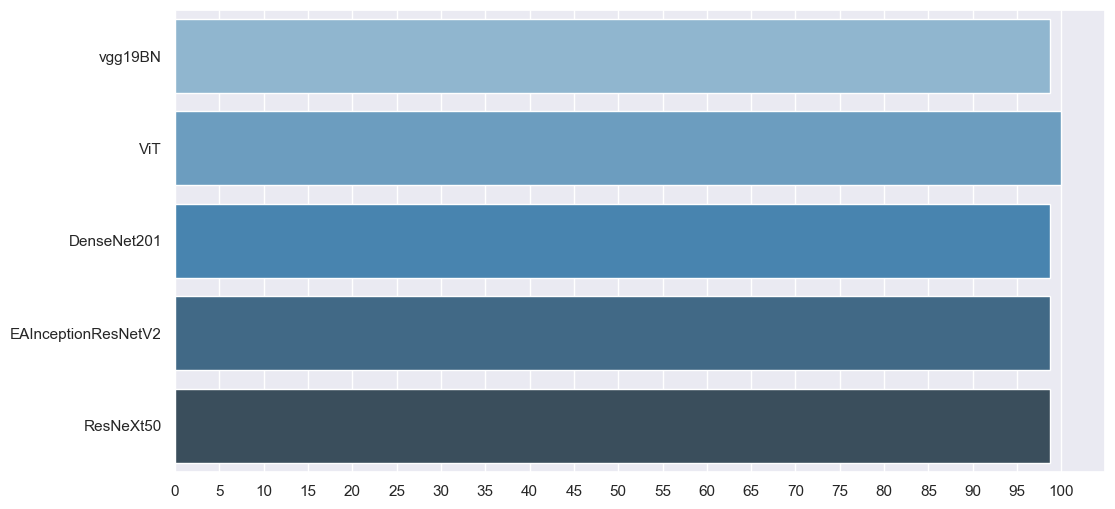

In [ ]:
def plot_model_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

#

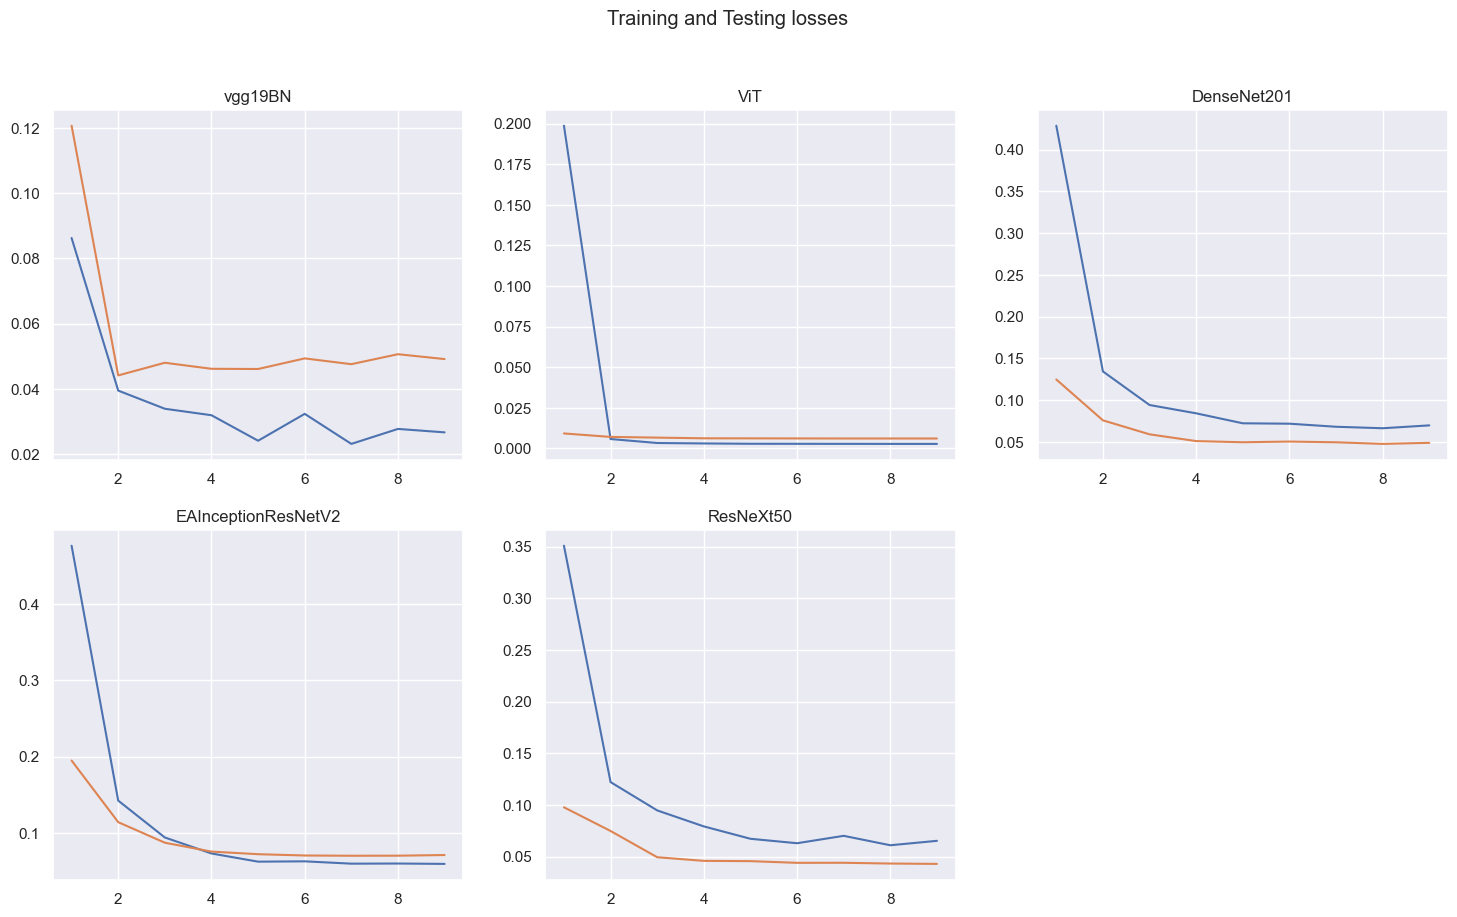

In [ ]:
def plot_multi_model_losses():
    model_acc = {'vgg19BN':[loss_train_vgg, loss_test_vgg], 'ViT':[loss_train_vit, loss_test_vit],
                 'DenseNet201':[loss_train_dn, loss_test_dn], 'EAInceptionResNetV2':[loss_train_eairv, loss_test_eairv],
                 'ResNeXt50':[loss_train_rnx, loss_test_rnx]}
    sns.set()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training and Testing losses')
    idx = 0
    for x in range(2):
        for y in range(3):
            if idx < 5:
                sns.lineplot(ax=axes[x, y], x=range(1,10), y=model_acc[list(model_acc.keys())[idx]][0])
                sns.lineplot(ax=axes[x, y], x=range(1,10),
                             y=model_acc[list(model_acc.keys())[idx]][1]).set_title(list(model_acc.keys())[idx])
            idx += 1
    fig.delaxes(ax = axes[1,2])
            
            
plot_multi_model_losses()

In [ ]:
def plot_confusion_matrix(preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #getting the standard confusion matrix in text form
    cm = confusion_matrix(np.asarray(true_labels), np.asarray(preds))
    #using the matrix generated as means to plot a confusion matrix graphically
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Confusion Matrix of VGG-19 with BatchNormalization

Confusion matrix, without normalization


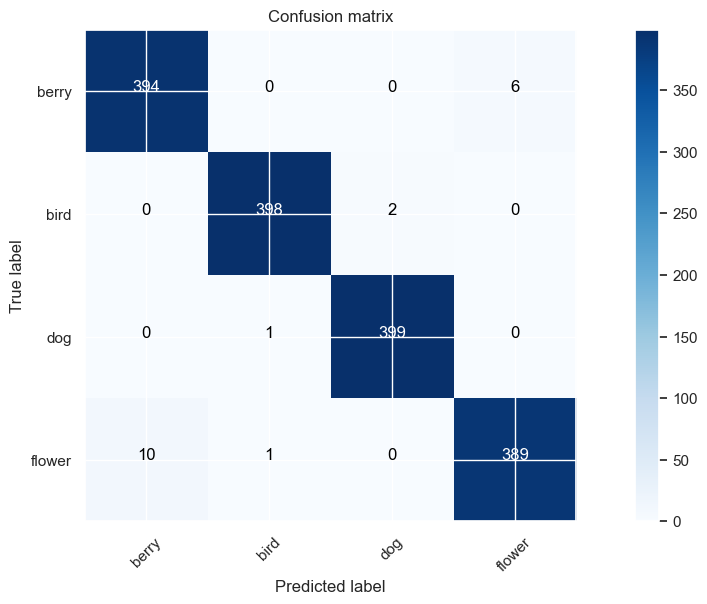

In [ ]:
plot_confusion_matrix(vgg19_bn_hard, CLASSES)


#Confusion Matrix of DenseNet201 classifier

Confusion matrix, without normalization


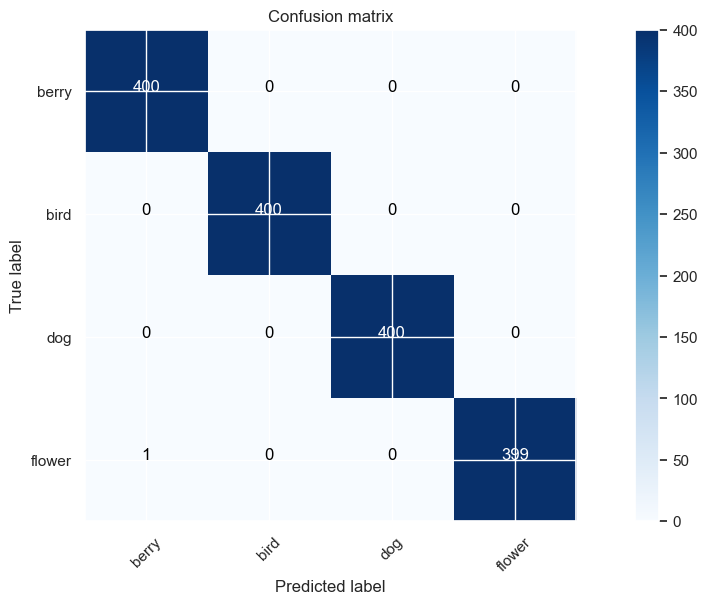

In [ ]:
plot_confusion_matrix(vit_hard, CLASSES)

#Confusion Matrix of ResNeXt50 classifier

Confusion matrix, without normalization


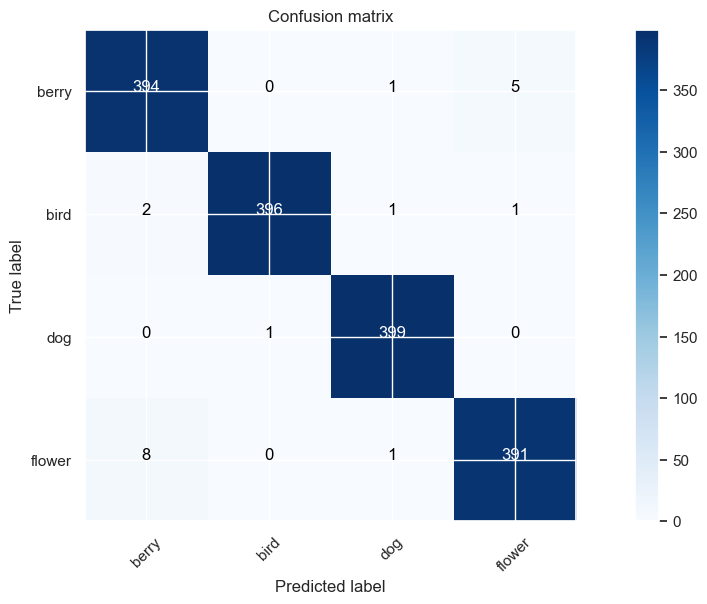

In [ ]:
plot_confusion_matrix(densenet201_hard, CLASSES)

#Confusion Matrix of Vision Transformer (ViT)

Confusion matrix, without normalization


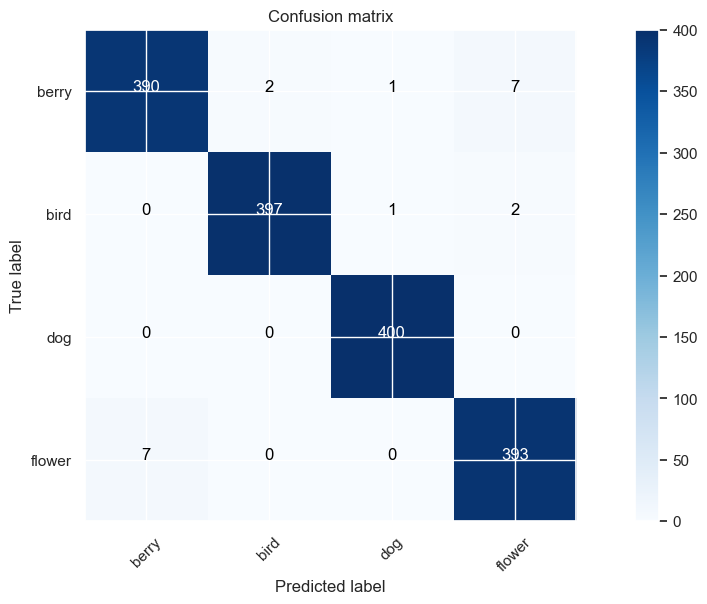

In [ ]:
plot_confusion_matrix(ensemble_adv_incres_v2_hard, CLASSES)

#Confusion Matrix of Ensemble Adversarial Inception-ResNet v2

Confusion matrix, without normalization


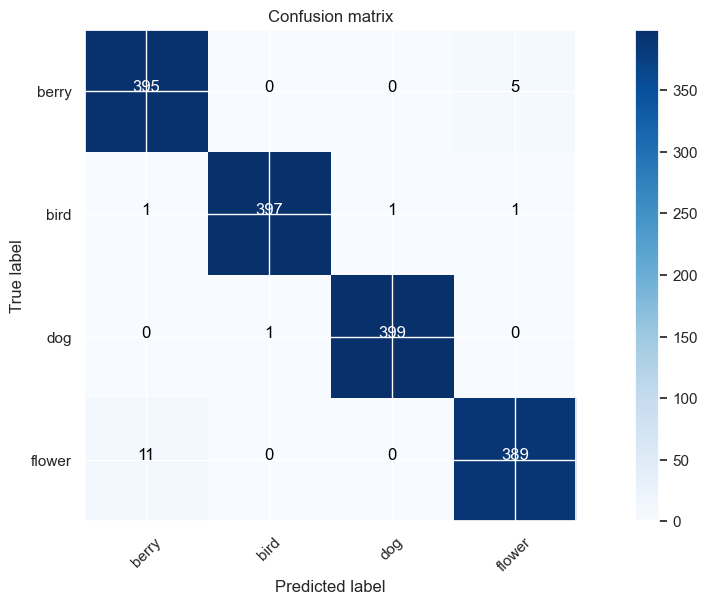

In [ ]:
plot_confusion_matrix(resnext50_hard, CLASSES)

***The analysis clearly shows that the approach with ensemble adversarial inception resent v2 is not overfitted and underfitted. I understand for this particular dataset the approaches will take a huge time and space complexity, apart from that if we take the issue as a critical mdeical image classification and segmentation the accuracy must be prominent. In the future we must optimize the models and reduce time and space complexity for ensuring robust image classification***